# Проект e-commerce: вариант 1 

Продакт-менеджер Василий попросил вас проанализировать совершенные покупки и ответить на следующие вопросы:

1. Сколько у нас пользователей, которые совершили покупку только один раз?

2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)?

3. По каждому товару определить, в какой день недели товар чаще всего покупается.

4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть.

5. Используя pandas, проведи когортный анализ пользователей. В период с января по декабрь выяви когорту с самым высоким retention на 3й месяц.

6. Часто для качественного анализа аудитории использую подходы, основанные на сегментации. Используя python, построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию. В кластеризации можешь выбрать следующие метрики: R - время от последней покупки пользователя до текущей даты, F - суммарное количество покупок у пользователя за всё время, M - сумма покупок за всё время. Подробно опиши, как ты создавал кластеры. Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров. Пример такого описания: RFM-сегмент 132 (recency=1, frequency=3, monetary=2) имеет границы метрик recency от 130 до 500 дней, frequency от 2 до 5 заказов в неделю, monetary от 1780 до 3560 рублей в неделю.

Для решения задачи проведи предварительное исследование данных и сформулируй, что должно считаться покупкой. Обосновать свой выбор ты можешь с помощью фактов оплат, статусов заказов и других имеющихся данных.

In [1]:
import pandas as pd
from datetime import timedelta
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px

In [2]:
#изменяет формат графиков на png, для возможности отображения в GitHub.
#*необходим только для публикации. В рамках анализа лучше не использовать, для возможности просмотра точных цифр на графиках.
import plotly.io as pio
pio.renderers.default = 'png'

Считам данные по трем таблицам:

In [3]:
customers_df = pd.read_csv('C:/Users/Julia/HEXProjects/datasets/e-commerce/olist_customers_dataset.csv')

In [4]:
customers_df.head() #таблица с уникальными идентификаторами пользователей

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


Размер таблицы (99441, 5)\
customer_id (тип данных object) — позаказный идентификатор пользователя\
customer_unique_id (object) —  уникальный идентификатор пользователя  (аналог номера паспорта)\
customer_zip_code_prefix (int64) —  почтовый индекс пользователя\
customer_city (object) —  город доставки пользователя\
customer_state (object) —  штат доставки пользователя

In [5]:
orders_df = pd.read_csv('C:/Users/Julia/HEXProjects/datasets/e-commerce/olist_orders_dataset.csv', parse_dates=['order_purchase_timestamp','order_approved_at','order_delivered_carrier_date','order_delivered_customer_date','order_estimated_delivery_date'])

In [6]:
orders_df.head() #таблица заказов

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26


In [7]:
orders_df.dtypes #убедимся, что столбцы с датами приведены с необходимому типу данных

order_id                                 object
customer_id                              object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_approved_at                datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
dtype: object

Размер таблицы (99441, 8)\
order_id —  уникальный идентификатор заказа (номер чека)\
customer_id —  позаказный идентификатор пользователя\
order_status —  статус заказа\
order_purchase_timestamp —  время создания заказа\
order_approved_at —  время подтверждения оплаты заказа\
order_delivered_carrier_date —  время передачи заказа в логистическую службу\
order_delivered_customer_date —  время доставки заказа\
order_estimated_delivery_date —  обещанная дата доставки

Уникальные статусы заказов в таблице olist_orders_dataset:

created —  создан\
approved —  подтверждён\
invoiced —  выставлен счёт\
processing —  в процессе сборки заказа\
shipped —  отгружен со склада\
delivered —  доставлен пользователю\
unavailable —  недоступен\
canceled —  отменён

In [8]:
order_items_df = pd.read_csv('C:/Users/Julia/HEXProjects/datasets/e-commerce/olist_order_items_dataset.csv', parse_dates=['shipping_limit_date'])

In [9]:
order_items_df.head() #товарные позиции, входящие в заказы

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


Размер таблицы (112650, 7)\
order_id (object) —  уникальный идентификатор заказа (номер чека)\
order_item_id (int64) —  идентификатор товара внутри одного заказа\
product_id (object) —  ид товара (аналог штрихкода)\
seller_id (object) — ид производителя товара\
shipping_limit_date (datetime64[ns]) —  максимальная дата доставки продавцом для передачи заказа партнеру по логистике\
price (float64) —  цена за единицу товара\
freight_value (float64) —  вес товара

# Задание 1
Вычислим, сколько пользователей совершили покупку только один раз.

In [10]:
orders_df.notna().sum() #проверим, сколько данных есть в таблцие с заказами.

order_id                         99441
customer_id                      99441
order_status                     99441
order_purchase_timestamp         99441
order_approved_at                99281
order_delivered_carrier_date     97658
order_delivered_customer_date    96476
order_estimated_delivery_date    99441
dtype: int64

Всего покупателями было сделано 99441 заказов, но при этом оплачено 99281 из них. За факт покупки будем считать именно факт оплаты заказа.

Для начала соединим данные таблицы заказов с данными таблицы покупателей, где указаны уникальные ID.\
Это необходимо для того, что удостовериться, что заказы закреплены за конкретным зарегистрированным пользователем.

In [11]:
orders_with_uniqcustomers = orders_df.merge(customers_df, on='customer_id', how='inner')

In [12]:
orders_with_uniqcustomers.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,barreiras,BA
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP


Размер полученной таблицы (99441, 12).\
Далее вычислим количество уникальных покупателей, совершивших только одну покупку.
Для этого отфильтрыем оплаченные заказы, сгруппируем по уникальному ID покупателя и агрегируем по заказам:

In [13]:
customers_with_1_purchase = orders_with_uniqcustomers.query('order_approved_at != "NaT"')\
    .groupby('customer_unique_id', as_index=False)\
    .agg({'order_id':'count'})\
    .rename(columns={'order_id':'purchases'})\
    .query('purchases == 1')\
    .shape[0]

In [14]:
customers_with_1_purchase

93049

Вывод: Количество уникальных пользователей, которые совершили только 1 покупку - 93049.

# Задание 2
Вычислим, сколько заказов в месяц в среднем не доставляется по разным причинам (выведем детализацию по причинам).\
Для начала вычислим, сколько в среднем происходит доставка товара в тот или иной регион:

In [15]:
orders_with_uniqcustomers['delivery_time'] = orders_with_uniqcustomers.order_delivered_customer_date - orders_with_uniqcustomers.order_purchase_timestamp
orders_with_uniqcustomers['delivery_time'] = orders_with_uniqcustomers.apply(lambda x:x['delivery_time'].days, axis =1)

Для подсчета среднего времени доставки в определенный регион сначала сгруппируем данные по городу покупателя:

In [16]:
delivery_time = orders_with_uniqcustomers.groupby(['customer_city'], as_index=False)\
    .agg({'delivery_time':'mean'})\
    .rename(columns={'delivery_time':'avg_delivery_time'})

Переведем полученное средннее время доставки по городам в timedelta для совершения дальнейших расчетов:

In [17]:
delivery_time.avg_delivery_time = pd.to_timedelta(delivery_time['avg_delivery_time'],unit = 'D')

In [18]:
delivery_time.head()

,customer_city,avg_delivery_time
0,abadia dos dourados,11 days 07:59:59.999971200
1,abadiania,29 days 00:00:00
2,abaete,9 days 22:00:00.000028800
3,abaetetuba,26 days 13:05:27.272688
4,abaiara,35 days 00:00:00


Далее примерджим полученные сведение о среднем времени доставки в регион к таблице с заказами, чтобы вычислить в какой месяц предположительно заказ был бы доставлен / не доставлен.

In [19]:
orders_with_uniqcustomers = orders_with_uniqcustomers.merge(delivery_time, on='customer_city', how='inner')

Отфильтруем только те заказы, где не указана дата доставки товара покупателю:

In [20]:
undelivered_orders = orders_with_uniqcustomers.query('order_status != "delivered" & order_delivered_customer_date =="NaT"')

In [21]:
undelivered_orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,delivery_time,avg_delivery_time
23,15bed8e2fec7fdbadb186b57c46c92f2,f3f0e613e0bdb9c7cee75504f0f90679,processing,2017-09-03 14:22:03,2017-09-03 14:30:09,NaT,NaT,2017-10-03,9f269af9c49244f6ba4a46985a3cfc2e,3436,sao paulo,SP,NaN,7 days 14:29:46.840358400
50,d3c8851a6651eeff2f73b0e011ac45d0,957f8e082185574de25992dc659ebbc0,processing,2016-10-05 22:44:13,2016-10-06 15:51:05,NaT,NaT,2016-12-09,07d5b1f9bdd053347f0213187b343ac9,3531,sao paulo,SP,NaN,7 days 14:29:46.840358400
59,1b9ecfe83cdc259250e1a8aca174f0ad,6d6b50b66d79f80827b6d96751528d30,canceled,2018-08-04 14:29:27,2018-08-07 04:10:26,NaT,NaT,2018-08-14,8ea097b1824dbd4d17af71b0afe04301,5514,sao paulo,SP,NaN,7 days 14:29:46.840358400
68,95e42e6aaf6264cd3e77c06b32dc3003,29ef1f160ce630146dafa02052e2c5bf,shipped,2017-11-24 09:23:33,2017-11-24 10:51:26,2017-11-24 19:07:43,NaT,2017-12-08,68e9aca85421a3dc655325bcdf9c9912,3271,sao paulo,SP,NaN,7 days 14:29:46.840358400
106,37553832a3a89c9b2db59701c357ca67,7607cd563696c27ede287e515812d528,unavailable,2017-08-14 17:38:02,2017-08-17 00:15:18,NaT,NaT,2017-09-05,596ed6d7a35890b3fbac54ec01f69685,2318,sao paulo,SP,NaN,7 days 14:29:46.840358400


Размер полученной таблицы (2957, 14).

In [22]:
round(undelivered_orders.shape[0]/12,0)
#В среднем в месяц не доставляется заказов.

246.0

Обновим данные о предполагаемой дате доставки, согласно нашим предыдущим вычислениям:

In [23]:
undelivered_orders['not_delivered_in_that_month'] = undelivered_orders.order_purchase_timestamp + undelivered_orders.avg_delivery_time

C:\Users\Julia\AppData\Local\Temp\ipykernel_10508\333280863.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



При этом в каких-то заказах не получлось рассчитать дату доставки вручную:

In [24]:
undelivered_orders.query('not_delivered_in_that_month == "NaT"').head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,delivery_time,avg_delivery_time,not_delivered_in_that_month
77132,9a01e11eb3e82a6d9e7bd3f3acafa7ca,49206e681a7405da8d06cf16883575ff,shipped,2018-03-02 22:07:38,2018-03-03 15:35:24,2018-03-06 00:04:29,NaT,2018-04-02,b500d09f227a12798d03911752d1c7d6,95717,pinto bandeira,RS,NaN,NaT,NaT
85395,3ff9af2618b202584a161c19718bf577,044e10a1e867fefd7f02a3da2ca475b4,shipped,2018-01-07 08:04:11,2018-01-07 08:11:23,2018-01-15 11:24:25,NaT,2018-02-05,e186ed0b619ff1dd7eef17b1ba5c4831,86610,jaguapita,PR,NaN,NaT,NaT
85800,dee6298ce7d1fb2645141ef9972157aa,c35fd04a09c83d6f53b2d4557eab7445,shipped,2018-04-30 14:06:12,2018-04-30 14:15:24,2018-04-30 12:59:00,NaT,2018-05-28,6776ae9432a76cace1d54a6fd1abcc57,75630,mairipotaba,GO,NaN,NaT,NaT
91981,f351ab7501d0f1d1874843df793c2fa6,39ca314818a8fcf7275bdd62444be657,invoiced,2017-10-10 20:54:00,2017-10-10 21:07:14,NaT,NaT,2017-11-14,36516895f52da0be70add0bd202cae06,58278,jacarau,PB,NaN,NaT,NaT
92284,c27a115ea191ed9bad73dac2e0ce82bd,4cf5f0dfd3a202391d614d12d82d03ee,shipped,2017-04-19 12:17:30,2017-04-19 13:06:27,2017-04-19 14:56:02,NaT,2017-05-11,36b57786cc39805025da0affca9d5bd5,35894,dores de guanhaes,MG,NaN,NaT,NaT


В таких случаях предлагаю использовать предполагаемую дату доставки, рассчитанную системой. Заменим отсутсвующие значения в not_delivered_in_that_month имеющимися в order_estimated_delivery_date: 

In [25]:
undelivered_orders.loc[undelivered_orders['not_delivered_in_that_month'].isna(), 'not_delivered_in_that_month'] = undelivered_orders.loc[undelivered_orders['not_delivered_in_that_month'].isna(), 'order_estimated_delivery_date']

In [26]:
undelivered_orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,delivery_time,avg_delivery_time,not_delivered_in_that_month
23,15bed8e2fec7fdbadb186b57c46c92f2,f3f0e613e0bdb9c7cee75504f0f90679,processing,2017-09-03 14:22:03,2017-09-03 14:30:09,NaT,NaT,2017-10-03,9f269af9c49244f6ba4a46985a3cfc2e,3436,sao paulo,SP,NaN,7 days 14:29:46.840358400,2017-09-11 04:51:49.840358400
50,d3c8851a6651eeff2f73b0e011ac45d0,957f8e082185574de25992dc659ebbc0,processing,2016-10-05 22:44:13,2016-10-06 15:51:05,NaT,NaT,2016-12-09,07d5b1f9bdd053347f0213187b343ac9,3531,sao paulo,SP,NaN,7 days 14:29:46.840358400,2016-10-13 13:13:59.840358400
59,1b9ecfe83cdc259250e1a8aca174f0ad,6d6b50b66d79f80827b6d96751528d30,canceled,2018-08-04 14:29:27,2018-08-07 04:10:26,NaT,NaT,2018-08-14,8ea097b1824dbd4d17af71b0afe04301,5514,sao paulo,SP,NaN,7 days 14:29:46.840358400,2018-08-12 04:59:13.840358400
68,95e42e6aaf6264cd3e77c06b32dc3003,29ef1f160ce630146dafa02052e2c5bf,shipped,2017-11-24 09:23:33,2017-11-24 10:51:26,2017-11-24 19:07:43,NaT,2017-12-08,68e9aca85421a3dc655325bcdf9c9912,3271,sao paulo,SP,NaN,7 days 14:29:46.840358400,2017-12-01 23:53:19.840358400
106,37553832a3a89c9b2db59701c357ca67,7607cd563696c27ede287e515812d528,unavailable,2017-08-14 17:38:02,2017-08-17 00:15:18,NaT,NaT,2017-09-05,596ed6d7a35890b3fbac54ec01f69685,2318,sao paulo,SP,NaN,7 days 14:29:46.840358400,2017-08-22 08:07:48.840358400


Так как у нас не имеются данные о конкретной дате, когда товар считается не доставленым, мы посчитали приблизительную дату. В каких-то случаях, наша дата значительно отличается от тех дат, которые рассчитывала система.\
Переведем предполагаемую дату доставки (вычисленную вручную, на основании среднего времени доставки товара по городам) в месяц, чтобы посчитать, сколько недоставленных заказов приходится на конкретный месяц.

In [27]:
undelivered_orders['not_delivered_in_that_month'] = undelivered_orders.not_delivered_in_that_month.dt.month_name()

C:\Users\Julia\AppData\Local\Temp\ipykernel_10508\3313474628.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Сгруппируем данные по месяцу, когда товар не был доставлен и статусу заказа, а так же посчитаем количество недоствленных заказов:

In [28]:
avg_undelivered_orders = undelivered_orders.groupby(['not_delivered_in_that_month','order_status'], as_index=False)\
    .agg({'order_id':'count'})\
    .rename(columns={'order_id':'undelivered_orders'})

In [29]:
avg_undelivered_orders.head()

,not_delivered_in_that_month,order_status,undelivered_orders
0,April,canceled,38
1,April,invoiced,25
2,April,processing,23
3,April,shipped,160
4,April,unavailable,22


Из полученных данных составим сводную таблицу для дальнейшего анализа:

In [30]:
df_pivot = avg_undelivered_orders.pivot(index='order_status',columns='not_delivered_in_that_month',values='undelivered_orders').fillna(0)
df_pivot

not_delivered_in_that_month,April,August,December,February,January,July,June,March,May,November,October,September
order_status,,,,,,,,,,,,
approved,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
canceled,38.0,107.0,14.0,88.0,8.0,51.0,40.0,73.0,50.0,40.0,49.0,61.0
created,0.0,0.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
invoiced,25.0,44.0,31.0,27.0,13.0,9.0,16.0,24.0,46.0,23.0,36.0,20.0
processing,23.0,21.0,29.0,32.0,42.0,8.0,16.0,41.0,28.0,18.0,29.0,14.0
shipped,160.0,115.0,92.0,72.0,61.0,105.0,81.0,144.0,145.0,38.0,47.0,47.0
unavailable,22.0,50.0,78.0,74.0,45.0,63.0,29.0,58.0,38.0,66.0,59.0,27.0


Визуализируем данные:

In [31]:
sns.set(rc={'figure.figsize':(15,15)}) #поменяем размер фигур с помощью надсроек matplotlib

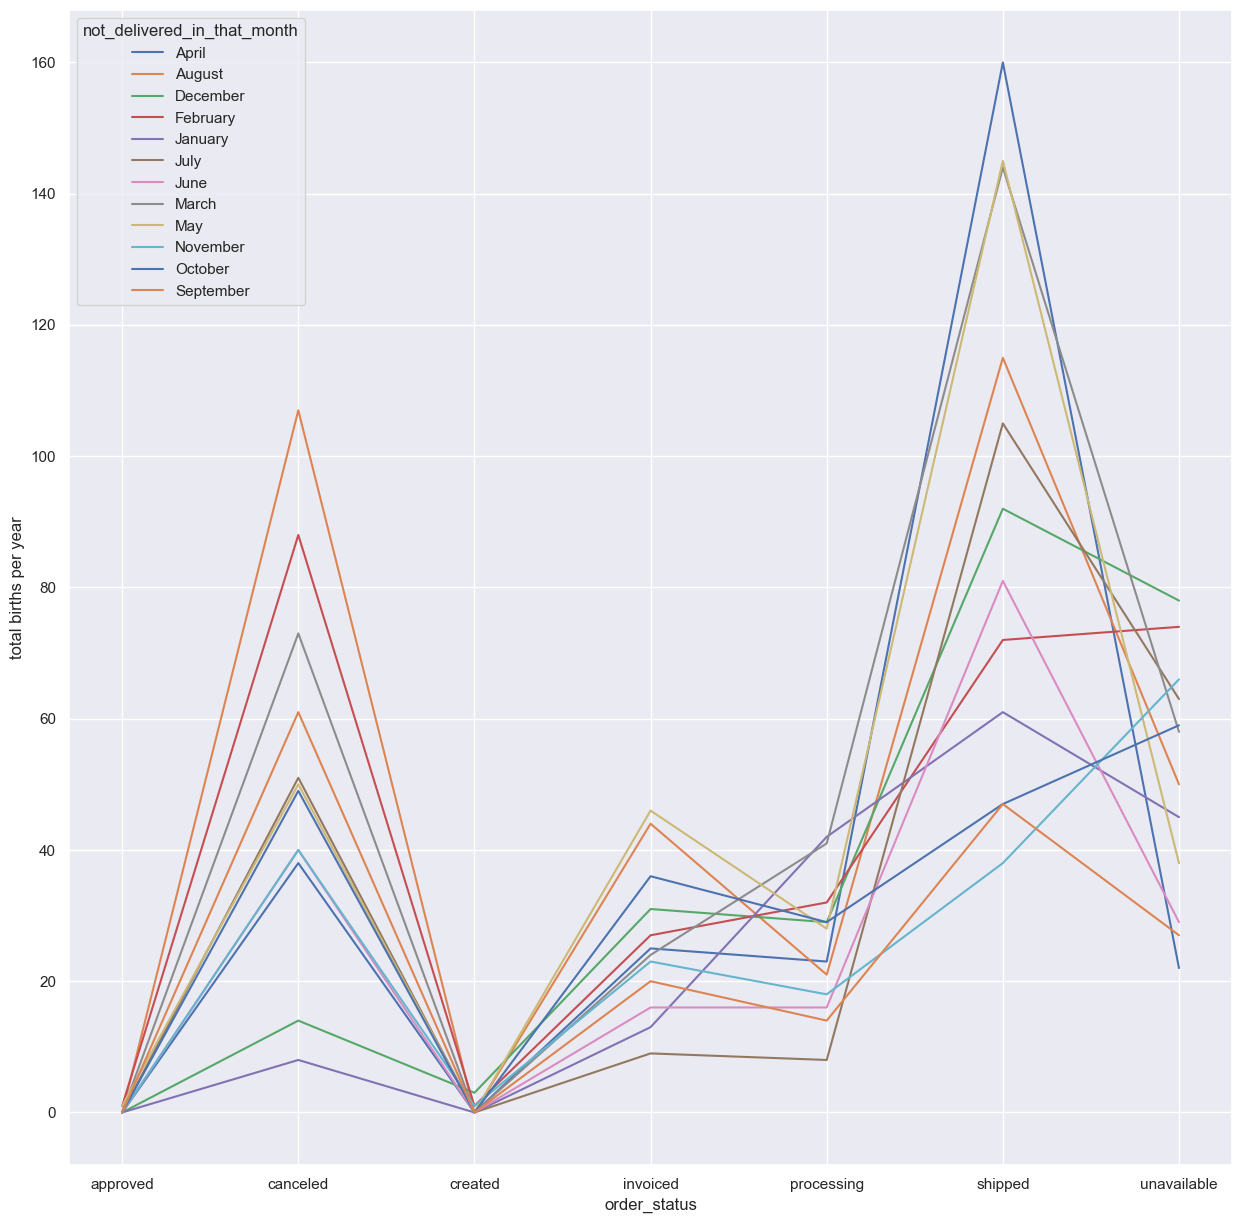

In [32]:
df_pivot.plot()
plt.ylabel('total births per year');

Далее вычислим среднее количество недоставленных заказов по месяцам: 

In [33]:
df_avg = pd.DataFrame(df_pivot.mean())\
    .reset_index()\
    .rename(columns={0:'average_amount'})\
    .round(2)\
    .sort_values('average_amount',ascending=False)
df_avg

,not_delivered_in_that_month,average_amount
7,March,48.57
1,August,48.14
8,May,44.00
3,February,42.14
0,April,38.29
2,December,35.29
5,July,33.71
10,October,31.43
9,November,26.57
6,June,26.00


Визуализируем полученные данные через библиотеку plotly:

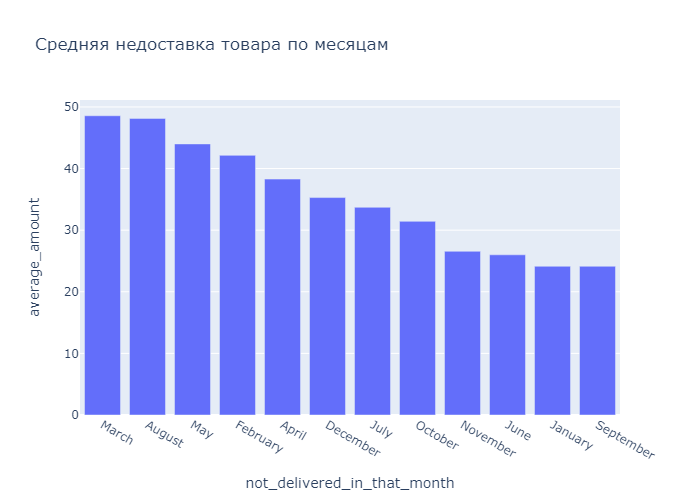

In [34]:
px.bar(df_avg, x='not_delivered_in_that_month', y='average_amount', title='Средняя недоставка товара по месяцам')

Из вышеуказанных данных следует вывод, что в среднем по месяцам больше всего заказов не доставялось в март и август.

Выведем детализацию, сколько всего заказов и по каким причинам не были доставлены:

In [35]:
detailing_undelivered_orders = undelivered_orders.groupby(['order_status'], as_index=False)\
    .agg({'order_id':'count'})\
    .rename(columns={'order_id':'undelivered_orders'})\
    .sort_values('undelivered_orders',ascending=False)

In [36]:
detailing_undelivered_orders

,order_status,undelivered_orders
5,shipped,1107
1,canceled,619
6,unavailable,609
3,invoiced,314
4,processing,301
2,created,5
0,approved,2


Визуализируем данные через библиотеку plotly:

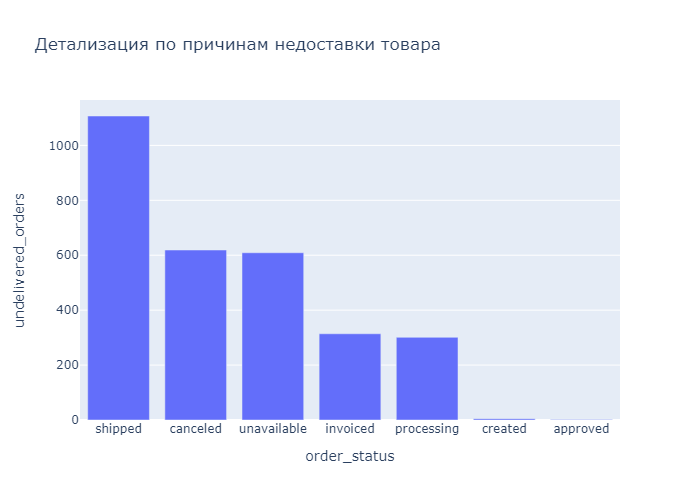

In [37]:
px.bar(detailing_undelivered_orders, x='order_status', y='undelivered_orders', title='Детализация по причинам недоставки товара')

Из вышеуказанных данных следует вывод, что 2 957 заказов из 99 441 не были доставлены по определенным причнам:\
1) Shipped - количество заказов, которые не были переданы покупателю службой доставки (например, заказ был утерян при доставке);\
2) Canceled - заказ отменен;\
3) Unaviable - заказ по какой-то причине недоступен (например, заказ был заблокирован операторами магазина);\
4) Invoiced - Заказ не был оплачен;\
5) Processing - Заказ не был собран;\
6) Created - Заказ сформирован, но на этом покупатель решил остановиться (такие заказы должны отменяться вручную операторами магазина или блокироваться автоматически по прошествии определенного времени);\
7) Approved - Заказ был оплачен, но не передан в службу доставки.

Из данных следует, что больше всего заказов не доставляется покупателям по вине перевозчиков.

# Задание 3
Определим по каждому товару, в какой день недели он чаще всего покупается.

Cоединим таблицу с данными заказов и таблицу с товарами для анализа, в какой день был куплен определенный товар:

In [38]:
orders_with_items = orders_df.merge(order_items_df, on='order_id', how='inner')

создадим столбец, в котором указан день денели, в который был совершен заказ:

In [39]:
orders_with_items['weekday'] = orders_with_items.order_purchase_timestamp.dt.strftime('%A')

Вычислим, в какой день недели товар покупается чаще всего.
Отфильтруем по факту покупки товара, сгруппируем по продукту и дням недели и посчитаем количество товаров, заказанных в этот день. После сорттировки удалим дубликаты, чтобы получить первый день, в который товар был куплен чаще всего:

In [40]:
items_weekday = orders_with_items.query('order_approved_at != "NaT"')\
    .groupby(['product_id','weekday'], as_index=False)\
    .agg({'order_id':'count'})\
    .sort_values(['product_id','weekday','order_id'],ascending=[True, False, False])\
    .rename(columns={'order_id':'count'})\
    .drop_duplicates('product_id')

В данной таблице приведен каждый товар и день недели в котором совершалось самое большее количество покупок данного товара:

In [41]:
items_weekday.head()

,product_id,weekday,count
0,00066f42aeeb9f3007548bb9d3f33c38,Sunday,1
1,00088930e925c41fd95ebfe695fd2655,Tuesday,1
2,0009406fd7479715e4bef61dd91f2462,Thursday,1
4,000b8f95fcb9e0096488278317764d19,Wednesday,1
5,000d9be29b5207b54e86aa1b1ac54872,Tuesday,1


# Задание 4
Вычислим, сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)?\
Для начала добавим месяц, в котором совершался заказ:

In [42]:
orders_with_uniqcustomers['month'] = orders_with_uniqcustomers.order_purchase_timestamp.dt.month_name()

Добавим столбец с количеством дней в месяце:

In [43]:
orders_with_uniqcustomers['week_in_month'] = orders_with_uniqcustomers.order_purchase_timestamp.dt.days_in_month

Получим данные об уникальных покупателях (во избежания задвоения) и количества их покупок (учитывая, что покупкой считаем тот факт, что товар обязательно был оплачен).
Сгруппируем по уникальному ID покупателя, месяцу покупки и дням в месяце и посчитаем количество заказов:

In [44]:
average_orders = orders_with_uniqcustomers.query('order_approved_at != "NaT"')\
    .groupby(['customer_unique_id','month','week_in_month'],as_index=False)\
    .agg({'order_id':'count'})\
    .rename(columns={'order_id':'orders'})

average_orders.head()

,customer_unique_id,month,week_in_month,orders
0,0000366f3b9a7992bf8c76cfdf3221e2,May,31,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,May,31,1
2,0000f46a3911fa3c0805444483337064,March,31,1
3,0000f6ccb0745a6a4b88665a16c9f078,October,31,1
4,0004aac84e0df4da2b147fca70cf8255,November,30,1


Вычислим количество недель в месяце и добавим столбец со средним числом покупок в неделю

In [45]:
average_orders['week_in_month'] = average_orders.week_in_month/7 #количество недель в месяце
average_orders['avg_week'] = average_orders.orders / average_orders.week_in_month  #добавляем столбец со средним числом покупок в неделю

In [46]:
average_orders = average_orders.sort_values(['customer_unique_id','avg_week'],ascending=[True, False])

Получаем данные о средних покупках пользователей в неделю по месяцам:

In [47]:
average_orders.head()

,customer_unique_id,month,week_in_month,orders,avg_week
0,0000366f3b9a7992bf8c76cfdf3221e2,May,4.428571,1,0.225806
1,0000b849f77a49e4a4ce2b2a4ca5be3f,May,4.428571,1,0.225806
2,0000f46a3911fa3c0805444483337064,March,4.428571,1,0.225806
3,0000f6ccb0745a6a4b88665a16c9f078,October,4.428571,1,0.225806
4,0004aac84e0df4da2b147fca70cf8255,November,4.285714,1,0.233333


# Задание 5
Проведем когортный анализ пользователей. В период с января по декабрь выявим когорту с самым высоким retention на 3й месяц.

Что нужно для когортного анализа?
Перед проведением когортного анализа определяют четыре параметра:

Признак формирования когорты — действие, которое объединяет людей в группу: первый визит, покупка, установка, регистрация и т.п.\
Размер когорты — временной интервал: день, неделя, месяц.\
Отчетный период — время исследования поведения групп.\
Анализируемый ключевой показатель: ROI, Retention Rate, LTV и т.д.\
Эти четыре параметра — столпы когортного анализа, определяются при работе в любой системе.

Отметим, что первый и последний параметры связаны между собой: признак определяют после выбора анализируемого ключевого показателя. Например, при оценке коэффициента повторных покупок в качестве признака выбирают «первую покупку».

У нас в базе присутствуют данные за 2016г., 2017г. и 2018г.\
Для получения достоверных данных, проведем когортный анализ на примере полного года, имеющегося в  наших данных - 2017г.

In [48]:
orders_with_uniqcustomers.order_estimated_delivery_date.dt.strftime('%Y-%m').drop_duplicates().sort_values()

30184    2016-09
12923    2016-10
497      2016-11
50       2016-12
44846    2017-01
112      2017-02
80       2017-03
31       2017-04
61       2017-05
117      2017-06
12       2017-07
1        2017-08
4        2017-09
0        2017-10
55       2017-11
13       2017-12
8        2018-01
6        2018-02
3        2018-03
9        2018-04
17       2018-05
19       2018-06
11       2018-07
2        2018-08
111      2018-09
16948    2018-10
73478    2018-11
Name: order_estimated_delivery_date, dtype: object

Вычислим месяц, в который покупка была совершена успешно:

In [49]:
orders_with_uniqcustomers['purchase_date'] = orders_with_uniqcustomers.order_approved_at.dt.strftime('%Y-%m')

Для получения достоверных данных, проведем когортный анализ на примере 2017 года, чтобы исключить редкие случаи, когда фактически пользователи пользутся нашим магизном, к примеру 1 раз в год.
Для этого отфильтруем данные по факту покупки и по нужному году:

In [50]:
df_with_purchases = orders_with_uniqcustomers.dropna().query('order_approved_at != "NaT" & purchase_date.str.startswith("2017")')

In [51]:
df_with_purchases.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,delivery_time,avg_delivery_time,month,week_in_month,purchase_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,8.0,7 days 14:29:46.840358400,October,31,2017-10
1,34513ce0c4fab462a55830c0989c7edb,7711cf624183d843aafe81855097bc37,delivered,2017-07-13 19:58:11,2017-07-13 20:10:08,2017-07-14 18:43:29,2017-07-19 14:04:48,2017-08-08,782987b81c92239d922aa49d6bd4200b,4278,sao paulo,SP,5.0,7 days 14:29:46.840358400,July,31,2017-07
4,203096f03d82e0dffbc41ebc2e2bcfb7,d2b091571da224a1b36412c18bc3bbfe,delivered,2017-09-18 14:31:30,2017-09-19 04:04:09,2017-10-06 17:50:03,2017-10-09 22:23:46,2017-09-28,d699688533772c15a061e8ce81cb56df,4001,sao paulo,SP,21.0,7 days 14:29:46.840358400,September,30,2017-09
7,f70a0aff17df5a6cdd9a7196128bd354,456dc10730fbdba34615447ea195d643,delivered,2017-08-10 11:58:33,2017-08-12 02:45:24,2017-08-17 15:35:07,2017-08-18 14:28:02,2017-08-23,1974875b4a1d2e2ee6d586e3ba4d7602,5634,sao paulo,SP,8.0,7 days 14:29:46.840358400,August,31,2017-08
8,989225ba6d0ebd5873335f7e01de2ae7,816f8653d5361cbf94e58c33f2502a5c,delivered,2017-12-12 13:56:04,2017-12-14 13:54:13,2017-12-16 00:18:57,2018-01-03 18:03:36,2018-01-08,37363700139c1aef873bbcd916e57dfd,5778,sao paulo,SP,22.0,7 days 14:29:46.840358400,December,31,2017-12


Далее преобразуем данные:

In [52]:
df_with_purchases.set_index('customer_unique_id', inplace=True) #добавим индекс в наши данные по customer_unique_id
df_with_purchases['first_purchase'] = df_with_purchases.groupby(level=0)['purchase_date'].min() #добавим столбец с данными о том, в каком месяце была совершена первая покупка у уникального пользователя
df_with_purchases.reset_index(inplace=True) #переиндексируем df
df_with_purchases.insert(len(df_with_purchases.columns), 'total_purchases', 0, allow_duplicates=False) #создадим столбец в котором далее поместим количество заказов

Сгруппируем данные и вычислим количество уникальных пользователей и общее количество их заказов:

In [53]:
temp_df = df_with_purchases.groupby(['first_purchase', 'purchase_date'])
#создадим когорту 
cohorts_df = temp_df.agg({'customer_unique_id': 'nunique', 'total_purchases': 'count'})\
    .rename(columns={'customer_unique_id': 'total_customers'})

In [54]:
cohorts_df.head()

total_customers  total_purchases
first_purchase purchase_date                                  
2017-01        2017-01                    684              715
               2017-02                      3                3
               2017-03                      2                2
               2017-04                      1                1
               2017-05                      3                3

In [55]:
#создадим функцию, определяющую когорту
def cohort_period(df_with_purchases):
    df_with_purchases['cohort_period'] = np.arange(len(df_with_purchases)) + 1 # отсчет с 1
    return df_with_purchases
cohorts_df = cohorts_df.groupby(level=0).apply(cohort_period) #применим функцию к нашей таблице

C:\Users\Julia\AppData\Local\Temp\ipykernel_10508\226851073.py:5: FutureWarning:

Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)



Переиндексируем данные таким образом, что в индекс теперь входили период первой покупки и номер когорты:

In [56]:
cohorts_df.reset_index(inplace=True)
cohorts_df.set_index(['cohort_period','first_purchase'], inplace=True)

Создадим ряд, содержаший размер каждой когорты по дате первой покупки:

In [57]:
cohort_size = cohorts_df['total_customers'].groupby(level=1).first()
cohort_size

first_purchase
2017-01     684
2017-02    1612
2017-03    2511
2017-04    2233
2017-05    3452
2017-06    3044
2017-07    3710
2017-08    4081
2017-09    4025
2017-10    4294
2017-11    6927
2017-12    5490
Name: total_customers, dtype: int64

Получим когорты пользователей, которые продолжали совершать покупки в течении следующих месяцев, после первой покупки в 2017 году:

In [58]:
cohorts_df['total_customers'].unstack(0)

cohort_period,1,2,3,4,5,6,7,8,9,10,11
first_purchase,,,,,,,,,,,
2017-01,684.0,3.0,2.0,1.0,3.0,1.0,3.0,1.0,1.0,2.0,2.0
2017-02,1612.0,3.0,4.0,3.0,7.0,2.0,4.0,3.0,1.0,3.0,2.0
2017-03,2511.0,11.0,9.0,9.0,9.0,4.0,4.0,8.0,7.0,3.0,NaN
2017-04,2233.0,14.0,5.0,4.0,5.0,6.0,8.0,6.0,8.0,NaN,NaN
2017-05,3452.0,18.0,16.0,10.0,10.0,11.0,14.0,5.0,NaN,NaN,NaN
2017-06,3044.0,15.0,12.0,13.0,9.0,11.0,11.0,NaN,NaN,NaN,NaN
2017-07,3710.0,20.0,12.0,7.0,13.0,7.0,NaN,NaN,NaN,NaN,NaN
2017-08,4081.0,28.0,15.0,11.0,15.0,NaN,NaN,NaN,NaN,NaN,NaN
2017-09,4025.0,27.0,20.0,13.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Можно визуализировать данные через библиотеку seaborn:

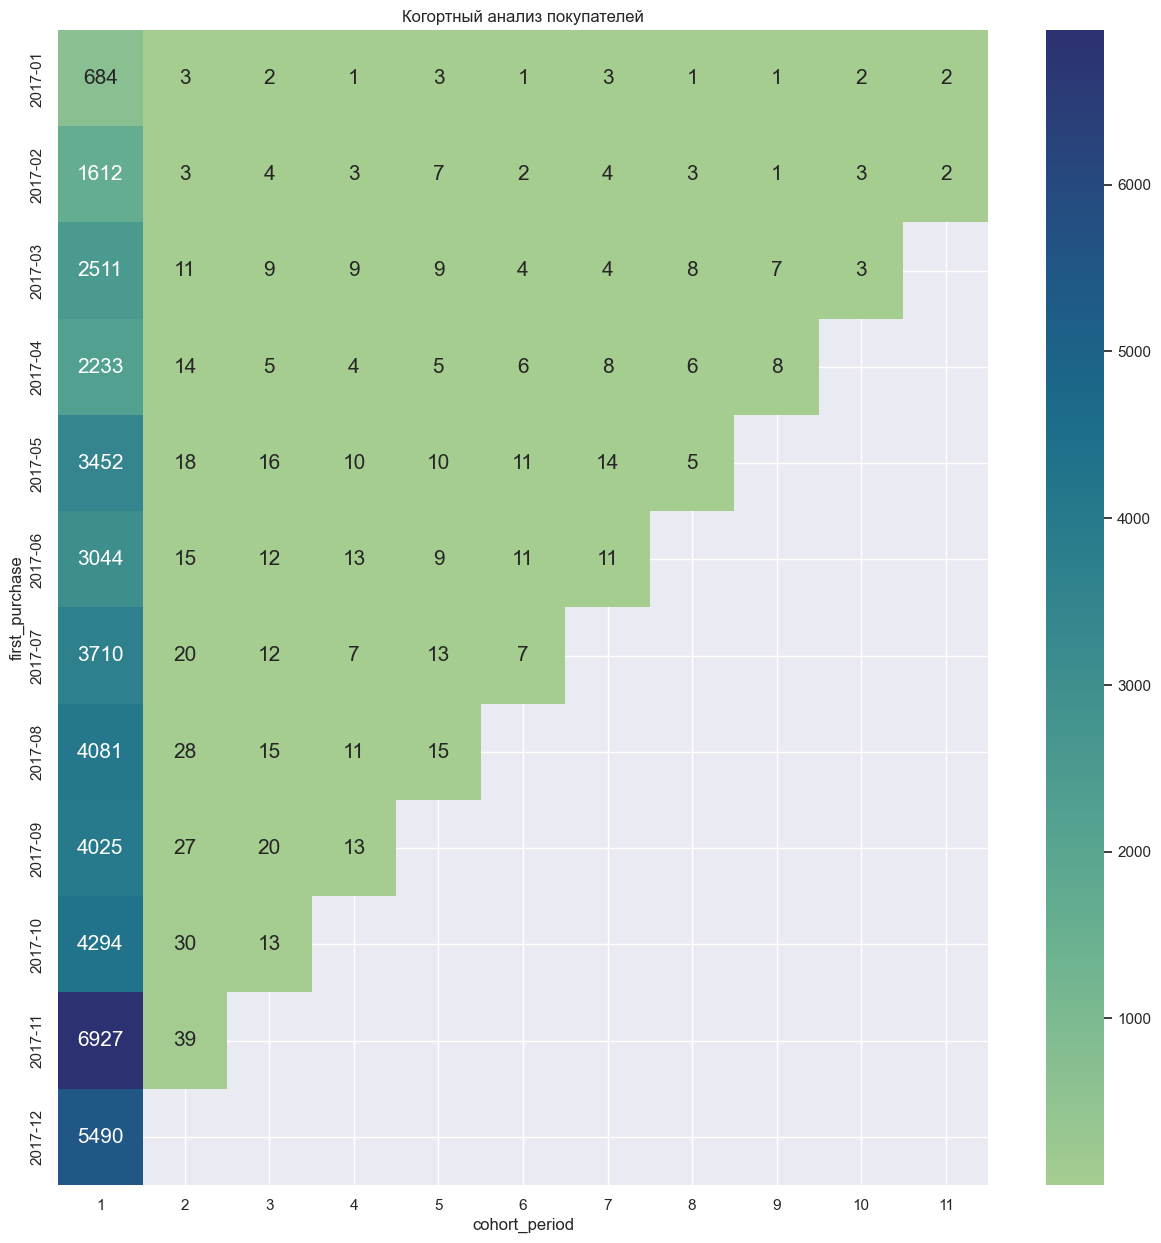

In [59]:
sns.heatmap(cohorts_df['total_customers'].unstack(0), cmap='crest', annot=True, annot_kws={"fontsize":15}, fmt='.0f').set_title('Когортный анализ покупателей')

plt.show()

Вычислим доли возврата от первоначального размера когорты:

In [60]:
retention_rate = cohorts_df['total_customers'].unstack(0).divide(cohort_size, axis=0)
retention_rate = round(retention_rate,4) #округлим данные для удобства

Получили данные об удерживаемости покупателей за 2017г., при этом установлено, что не было случаев, когда первая покупка у пользователя была совершена в декабре 2017г.

In [61]:
retention_rate

cohort_period,1,2,3,4,5,6,7,8,9,10,11
first_purchase,,,,,,,,,,,
2017-01,1.0,0.0044,0.0029,0.0015,0.0044,0.0015,0.0044,0.0015,0.0015,0.0029,0.0029
2017-02,1.0,0.0019,0.0025,0.0019,0.0043,0.0012,0.0025,0.0019,0.0006,0.0019,0.0012
2017-03,1.0,0.0044,0.0036,0.0036,0.0036,0.0016,0.0016,0.0032,0.0028,0.0012,NaN
2017-04,1.0,0.0063,0.0022,0.0018,0.0022,0.0027,0.0036,0.0027,0.0036,NaN,NaN
2017-05,1.0,0.0052,0.0046,0.0029,0.0029,0.0032,0.0041,0.0014,NaN,NaN,NaN
2017-06,1.0,0.0049,0.0039,0.0043,0.0030,0.0036,0.0036,NaN,NaN,NaN,NaN
2017-07,1.0,0.0054,0.0032,0.0019,0.0035,0.0019,NaN,NaN,NaN,NaN,NaN
2017-08,1.0,0.0069,0.0037,0.0027,0.0037,NaN,NaN,NaN,NaN,NaN,NaN
2017-09,1.0,0.0067,0.0050,0.0032,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [62]:
retention_rate[3].max()

0.005

Вывод: Установлено, что больше всего пользователей совершавших покупки в 2017г. 3 месяца подряд, начали пользоваться нашим магазином в сентябре 2017г.

# Задание 6
Построим RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию. В кластеризации выберем следующие метрики: R - время от последней покупки пользователя до текущей даты, F - суммарное количество покупок у пользователя за всё время, M - сумма покупок за всё время.\
Для каждого RFM-сегмента простроим границы метрик recency, frequency и monetary для интерпретации этих кластеров.

Для начала смерджим полученную ранее таблицу с уникальными пользователями с таблицей данных о товарах, для получения стоимости каждого заказа:

In [63]:
orders_with_price = orders_with_uniqcustomers.merge(order_items_df, on='order_id', how='inner')

In [64]:
orders_with_price.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,...,avg_delivery_time,month,week_in_month,purchase_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,...,7 days 14:29:46.840358400,October,31,2017-10,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72
1,34513ce0c4fab462a55830c0989c7edb,7711cf624183d843aafe81855097bc37,delivered,2017-07-13 19:58:11,2017-07-13 20:10:08,2017-07-14 18:43:29,2017-07-19 14:04:48,2017-08-08,782987b81c92239d922aa49d6bd4200b,4278,...,7 days 14:29:46.840358400,July,31,2017-07,1,f7e0fa615b386bc9a8b9eb52bc1fff76,87142160b41353c4e5fca2360caf6f92,2017-07-19 20:10:08,98.00,16.13
2,5ff96c15d0b717ac6ad1f3d77225a350,19402a48fe860416adf93348aba37740,delivered,2018-07-25 17:44:10,2018-07-25 17:55:14,2018-07-26 13:16:00,2018-07-30 15:52:25,2018-08-08,e2dfa3127fedbbca9707b36304996dab,4812,...,7 days 14:29:46.840358400,July,31,2018-07,1,10adb53d8faa890ca7c2f0cbcb68d777,1900267e848ceeba8fa32d80c1a5f5a8,2018-07-27 17:55:14,19.90,12.80
3,432aaf21d85167c2c86ec9448c4e42cc,3df704f53d3f1d4818840b34ec672a9f,delivered,2018-03-01 14:14:28,2018-03-01 15:10:47,2018-03-02 21:09:20,2018-03-12 23:36:26,2018-03-21,04cf8185c71090d28baa4407b2e6d600,5271,...,7 days 14:29:46.840358400,March,31,2018-03,1,72d3bf1d3a790f8874096fcf860e3eff,0bae85eb84b9fb3bd773911e89288d54,2018-03-07 15:10:47,38.25,16.11
4,203096f03d82e0dffbc41ebc2e2bcfb7,d2b091571da224a1b36412c18bc3bbfe,delivered,2017-09-18 14:31:30,2017-09-19 04:04:09,2017-10-06 17:50:03,2017-10-09 22:23:46,2017-09-28,d699688533772c15a061e8ce81cb56df,4001,...,7 days 14:29:46.840358400,September,30,2017-09,1,5ac9d9e379c606e36a8094a6046f75dc,633ecdf879b94b5337cca303328e4a25,2017-09-25 04:04:09,109.90,8.96


Размер полученной таблицы (112650, 23)

Вычислим количество заказов (F) уникального пользователя пользователя и стоимость всех его заказов (M).
Для этого отфильтруем данные по покупке и сгруппируем по уникальному ID пользователя:

In [65]:
orders_with_values = orders_with_price.query('order_approved_at != "NaT"').groupby('customer_unique_id', as_index=False)\
    .agg({'order_id':'count','price':'sum'})\
    .sort_values('order_id',ascending=False)\
    .rename(columns={'order_id':'order','price':'value'})

In [66]:
orders_with_values.head()

,customer_unique_id,order,value
74743,c8460e4251689ba205045f3ea17884a1,24,4080.00
25885,4546caea018ad8c692964e3382debd19,21,31.80
39442,698e1cf81d01a3d389d96145f7fa6df8,20,1974.00
73147,c402f431464c72e27330a67f7b94d4fb,20,2000.00
5741,0f5ac8d5c31de21d2f25e24be15bbffb,18,1252.35


Учитывая, что у нас имеются данные за 2016-2018г., для корректности расчета recency можем взять последню дату из имеющихся данных:

In [67]:
orders_with_price[['order_purchase_timestamp','order_approved_at','order_delivered_carrier_date','order_delivered_customer_date','order_estimated_delivery_date','shipping_limit_date']].max()

order_purchase_timestamp        2018-09-03 09:06:57
order_approved_at               2018-09-03 17:40:06
order_delivered_carrier_date    2018-09-11 19:48:28
order_delivered_customer_date   2018-10-17 13:22:46
order_estimated_delivery_date   2018-10-25 00:00:00
shipping_limit_date             2020-04-09 22:35:08
dtype: datetime64[ns]

Вычислим дату последнего заказа покупателя (R) для метрики RFM и переведем разницу в дни:

In [68]:
df_last = orders_with_price.sort_values('order_purchase_timestamp')\
    .groupby('customer_unique_id')\
    .last().reset_index()\
    .rename(columns={'order_purchase_timestamp':'date_of_last_order'})

In [69]:
df_last['time_since_last_order'] = orders_with_price.order_estimated_delivery_date.max() - df_last.date_of_last_order
df_last['time_since_last_order'] = df_last.apply(lambda x:x['time_since_last_order'].days, axis =1)

Оставим только необходимые данные:

In [70]:
df_last = df_last[['customer_unique_id','time_since_last_order']]
df_last.head()

,customer_unique_id,time_since_last_order
0,0000366f3b9a7992bf8c76cfdf3221e2,167
1,0000b849f77a49e4a4ce2b2a4ca5be3f,170
2,0000f46a3911fa3c0805444483337064,593
3,0000f6ccb0745a6a4b88665a16c9f078,377
4,0004aac84e0df4da2b147fca70cf8255,344


Примерджим к нашей табллице данные о последней покупке (R):

In [71]:
RFM = orders_with_values.merge(df_last, on='customer_unique_id', how='inner')

In [72]:
RFM.head()

,customer_unique_id,order,value,time_since_last_order
0,c8460e4251689ba205045f3ea17884a1,24,4080.00,77
1,4546caea018ad8c692964e3382debd19,21,31.80,465
2,698e1cf81d01a3d389d96145f7fa6df8,20,1974.00,427
3,c402f431464c72e27330a67f7b94d4fb,20,2000.00,244
4,0f5ac8d5c31de21d2f25e24be15bbffb,18,1252.35,331


Переименуем столбцы для наглядности метрики RFM:

In [73]:
RFM = RFM.rename(columns={'time_since_last_order':'recency','order':'frequency','value':'monetary'})
RFM = RFM[['customer_unique_id','recency','frequency','monetary']] #переместим местами столбы

In [74]:
RFM.head()

,customer_unique_id,recency,frequency,monetary
0,c8460e4251689ba205045f3ea17884a1,77,24,4080.00
1,4546caea018ad8c692964e3382debd19,465,21,31.80
2,698e1cf81d01a3d389d96145f7fa6df8,427,20,1974.00
3,c402f431464c72e27330a67f7b94d4fb,244,20,2000.00
4,0f5ac8d5c31de21d2f25e24be15bbffb,331,18,1252.35


Через метод describe() можно увидеть разницу между минимальной и максимальной стоимостью всех заказов:

In [75]:
RFM.describe()

,recency,frequency,monetary
count,95407.000000,95407.000000,95407.000000
mean,294.457409,1.180574,142.442098
std,153.124712,0.621478,217.667272
min,51.000000,1.000000,0.850000
25%,170.000000,1.000000,47.900000
50%,275.000000,1.000000,89.900000
75%,404.000000,1.000000,155.000000
max,780.000000,24.000000,13440.000000


Можно разделить покупателей на кластеры по 20%, 40%, 60% и 80% квантилю (к примеру покупатели, чья общая сумма заказов превышает 80% статистики или же покупатели, чья общая сумма заказов меньше 20% от статистики и тд.)

Создадим список с показателями квантилей 20%, 40%, 60%, 80% по интересующим метрикам recency и monetary.

In [76]:
quintilesRM = RFM[['recency', 'monetary']].quantile([.2, .4, .6, .8]).to_dict()
quintilesRM

{'recency': {0.2: 149.0, 0.4: 233.0, 0.6: 324.0, 0.8: 439.0},
 'monetary': {0.2: 39.9, 0.4: 69.9, 0.6: 109.9, 0.8: 179.9}}

Учитывая, что в frequency у нас 80% данных составляет 1 покупка, для этой метрики используем более тонкие квантили:

In [77]:
RFM.frequency.value_counts()

1     83540
2      8994
3      1672
4       632
5       254
6       198
7        46
8        16
9        11
10       11
11       11
12        9
14        3
13        2
15        2
20        2
21        1
16        1
18        1
24        1
Name: frequency, dtype: int64

Для дальнейших расчетов по метрике frequency предлагаю взять квантили 80%, 95%, 99% и 999%:

In [78]:
quintilesF = RFM[['frequency']].quantile([.8, .95, .99, .999]).to_dict()
quintilesF

{'frequency': {0.8: 1.0, 0.95: 2.0, 0.99: 4.0, 0.999: 7.0}}

Выведем функции, которая будет проводить ранжирование кластеров:

In [79]:
#Для R, чем меньше дней прошло с последней покупки - тем выше ранг.
def r_score(x, c):
    if x <= quintilesRM[c][.2]:
        return 5
    elif x <= quintilesRM[c][.4]:
        return 4
    elif x <= quintilesRM[c][.6]:
        return 3
    elif x <= quintilesRM[c][.8]:
        return 2
    else:
        return 1  

#Для M, чем выше стоимость всех заказов - тем выше ранг.
def m_score(x, c):
    if x <= quintilesRM[c][.2]:
        return 1
    elif x <= quintilesRM[c][.4]:
        return 2
    elif x <= quintilesRM[c][.6]:
        return 3
    elif x <= quintilesRM[c][.8]:
        return 4
    else:
        return 5  

#Для F выведем отдельную функцию, с учетом особенностей квантилей.
#Чем выше количество заказов заказов - тем выше ранг.
def f_score(x, c):
    if x <= quintilesF[c][.8]:
        return 1
    elif x <= quintilesF[c][.95]:
        return 2
    elif x <= quintilesF[c][.99]:
        return 3
    elif x <= quintilesF[c][.999]:
        return 4
    else:
        return 5

Применим функции для кластеризации пользователей по метрикам:

In [80]:
RFM['R'] = RFM['recency'].apply(lambda x: r_score(x, 'recency')).astype('string')
RFM['F'] = RFM['frequency'].apply(lambda x: f_score(x, 'frequency')).astype('string')
RFM['M'] = RFM['monetary'].apply(lambda x: m_score(x, 'monetary')).astype('string')

Убедимся, что кластеризация работает корректно:

In [81]:
RFM.head()

,customer_unique_id,recency,frequency,monetary,R,F,M
0,c8460e4251689ba205045f3ea17884a1,77,24,4080.00,5,5,5
1,4546caea018ad8c692964e3382debd19,465,21,31.80,1,5,1
2,698e1cf81d01a3d389d96145f7fa6df8,427,20,1974.00,2,5,5
3,c402f431464c72e27330a67f7b94d4fb,244,20,2000.00,3,5,5
4,0f5ac8d5c31de21d2f25e24be15bbffb,331,18,1252.35,2,5,5


Добавим итоговый подсчет по RFM:

In [82]:
RFM['RFM_Score'] = RFM.R+RFM.F+RFM.M

In [83]:
RFM.head()

,customer_unique_id,recency,frequency,monetary,R,F,M,RFM_Score
0,c8460e4251689ba205045f3ea17884a1,77,24,4080.00,5,5,5,555
1,4546caea018ad8c692964e3382debd19,465,21,31.80,1,5,1,151
2,698e1cf81d01a3d389d96145f7fa6df8,427,20,1974.00,2,5,5,255
3,c402f431464c72e27330a67f7b94d4fb,244,20,2000.00,3,5,5,355
4,0f5ac8d5c31de21d2f25e24be15bbffb,331,18,1252.35,2,5,5,255


Можем также вывести лидирующих покупателей по RFM метрике, для дальнешей работы с ними, например разработки для них персонального предложения и тд.:

In [84]:
RFM_top = RFM[RFM.RFM_Score == '555']
RFM_top

,customer_unique_id,recency,frequency,monetary,R,F,M,RFM_Score
0,c8460e4251689ba205045f3ea17884a1,77,24,4080.00,5,5,5,555
5,8d50f5eadf50201ccdcedfb9e2ac8455,65,16,729.62,5,5,5,555
13,ca77025e7201e3b30c44b472ff346268,145,12,806.61,5,5,5,555
19,07ff81a9676efa0286ddd3f09e7c0063,135,12,320.88,5,5,5,555
22,a5c6335399140e986db84120c425adf0,91,11,287.98,5,5,5,555
24,dc813062e0fc23409cd255f7f53c7074,62,11,687.76,5,5,5,555
25,63cfc61cee11cbe306bff5857d00bfe4,149,11,579.81,5,5,5,555
27,33176de67c05eeed870fd49f234387a0,142,11,1021.50,5,5,5,555
33,c8ed31310fc440a3f8031b177f9842c3,73,10,1138.30,5,5,5,555
34,aebdb8f05f5ebf99f858c1a75fb7035a,106,10,299.90,5,5,5,555


Вывод: получилось всего 13 пользователей лидирующих в нашей метрике.